In [1]:
import geopandas as gpd
import time
import os
import matplotlib.pyplot as plt
import json
import requests
import numpy as np
from osgeo import gdal
from matplotlib import pyplot
import rasterio
import rasterio.mask
from xml.dom.minidom import parse
import numpy
import pandas as pd
from requests.auth import HTTPBasicAuth
from dotenv import load_dotenv
import os
import requests
PLANET_API_KEY = "17de9ecc82734c1caf0ef0da1bf90d97"
import datetime


In [2]:
# Set filepath
fp = "shapes/trial-design-n-2021.shp"
# Read file using gpd.read_file()
trial_design = gpd.read_file(fp)
#str(data.iloc[0]['geometry'])
# check the data
#gpd.GeoSeries([data.iloc[0]['geometry']])
print(len(trial_design.index))
trial_design.head(2)

140


geometry
0  POLYGON ((-89.06084 39.72437, -89.06084 39.724...
1  POLYGON ((-89.06172 39.72437, -89.06172 39.724...

In [3]:
df = pd.read_csv('data/res.csv')
print(len(df.index))
df.head(3)
ids = [v.id for k,v in df.iterrows()]

34


In [11]:
from matplotlib import colors

# Credit: Joe Kington
class MidpointNormalize(colors.Normalize):
    """
    Normalize the colorbar so that diverging bars work there way either side from a prescribed midpoint value
    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

def show_ndvi(ndvi):
    
    # Begin by pulling in pyplot
    import matplotlib.pyplot as plt

    # Set min/max values from NDVI range for image
    # HINT: refer back to earlier, when we verified our min & max values were within expected range
    min=numpy.nanmin(ndvi)
    max=numpy.nanmax(ndvi)

    # Set our custom midpoint for most effective NDVI analysis
    mid=0.1

    # Set your favorite diverging color scheme 
    # You can use https://matplotlib.org/users/colormaps.html as a reference
    colormap = plt.cm.RdYlGn 

    # Call MidPointNormalize with our min, max, and custom midpoint
    norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)

    # Create a pyplot figure, in which we'll display our colorized NDVI
    fig = plt.figure(figsize=(10,5))

    # Add a subplot to our figure, which will contain the colorbar
    ax = fig.add_subplot(111)

    # Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
    cbar_plot = ax.imshow(ndvi, cmap=colormap, vmin=min, vmax=max, norm=norm)

    # Turn off the display of axis labels 
    ax.axis('off')

    # Set a title 
    ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

    # Configure the colorbar
    cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

    # Call 'savefig' to save this plot to an image file
    #fig.savefig("data/ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

    # Finally - let's take a look!
    plt.show()

In [12]:
for geom in trial_design.iterrows():
    print(geom[1])
    break

geometry    POLYGON ((-89.06083529248441 39.72436997827738...
Name: 0, dtype: object


In [13]:
def calc_ndvi(image_path, xml_path, out_path, cmap_out_path):
    my_image = rasterio.open(image_path)
    band_red = my_image.read(3)
    band_nir = my_image.read(4)
    xmldoc = parse(xml_path)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")
    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)

    # Multiply by corresponding coefficients
    band_red = band_red * coeffs[3]
    band_nir = band_nir * coeffs[4]
    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')

    # Calculate NDVI
    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

    # Set spatial characteristics of the output object to mirror the input
    kwargs = my_image.meta
    kwargs.update(
        driver='GTiff',
        dtype=rasterio.float32,
        count = 1)
    #print(kwargs)
    show_ndvi(ndvi)
    #ndvi *= 255
    with rasterio.open(out_path, 'w', **kwargs) as dst:
        dst.write(ndvi.astype(rasterio.float32), indexes=1)
    #img_plt = ndvi.astype('uint8')
    #plt.imshow(ndvi, cmap=plt.cm.summer)
    #plt.savefig(cmap_out_path)
    #print(cmap_out_path)
    #plt.imshow(ndvi, cmap=plt.cm.summer)
    #plt.show()
    return ndvi

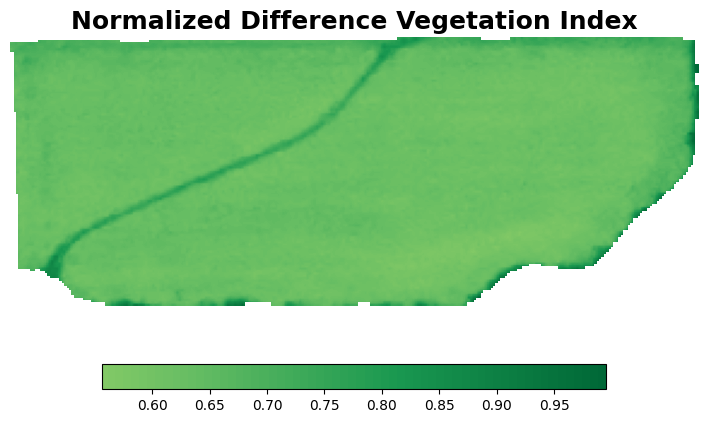

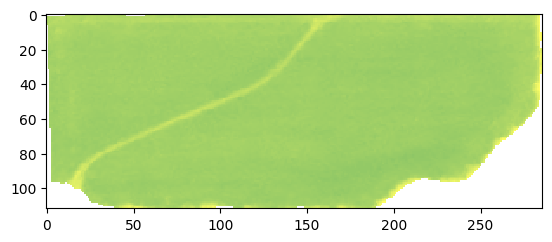

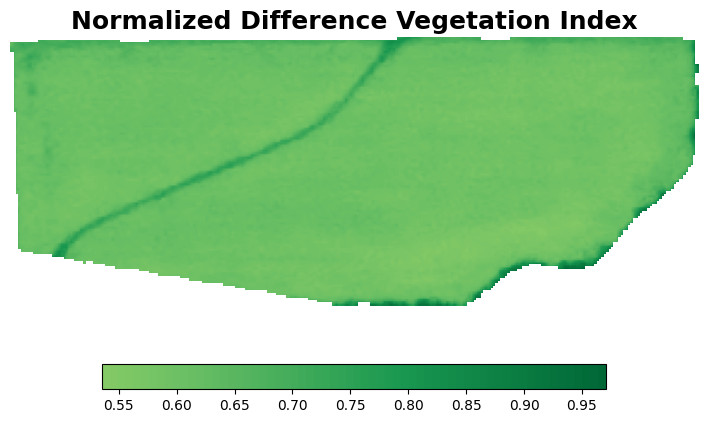

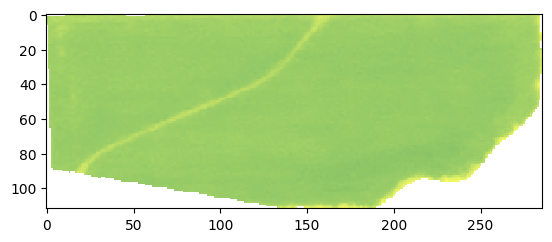

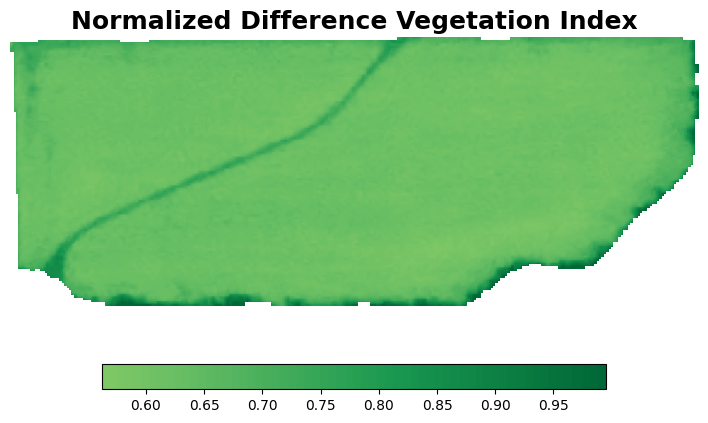

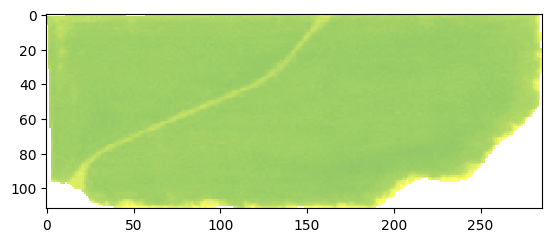

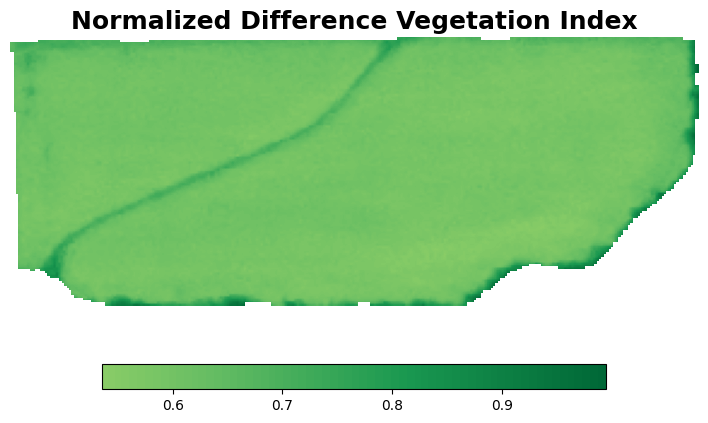

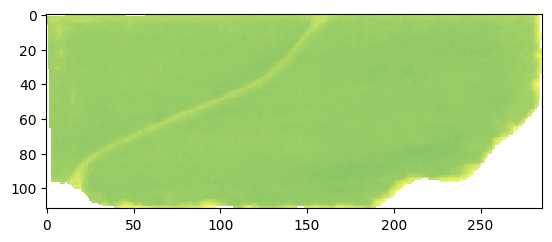

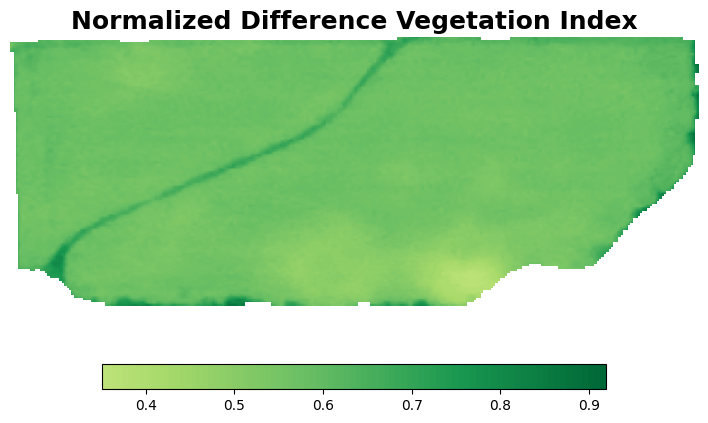

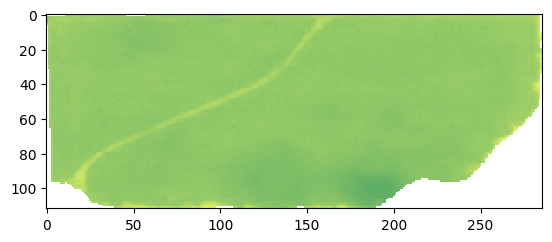

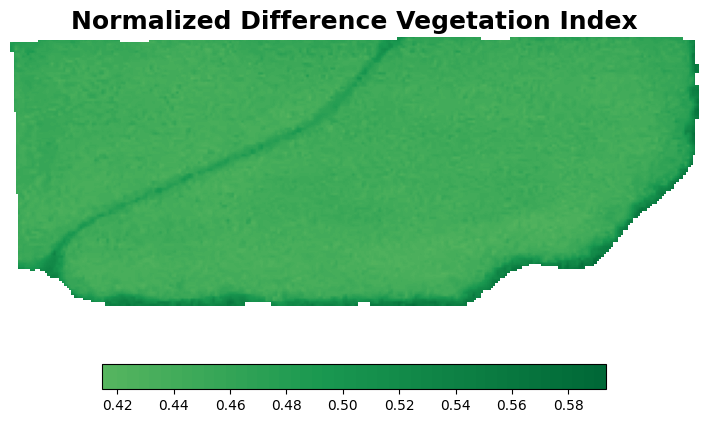

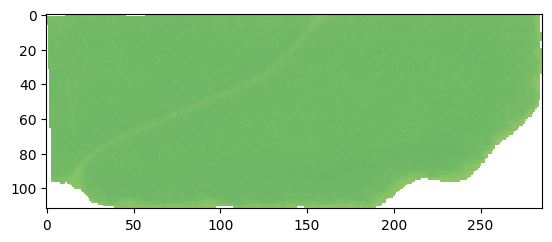

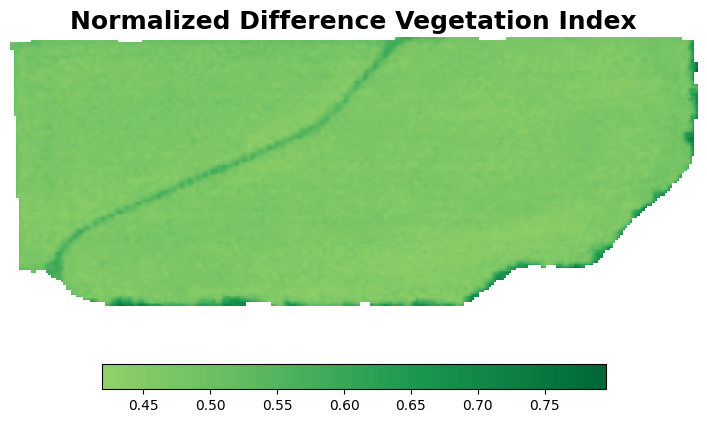

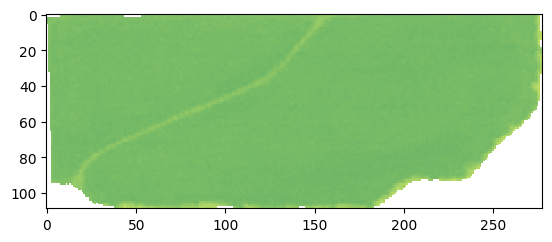

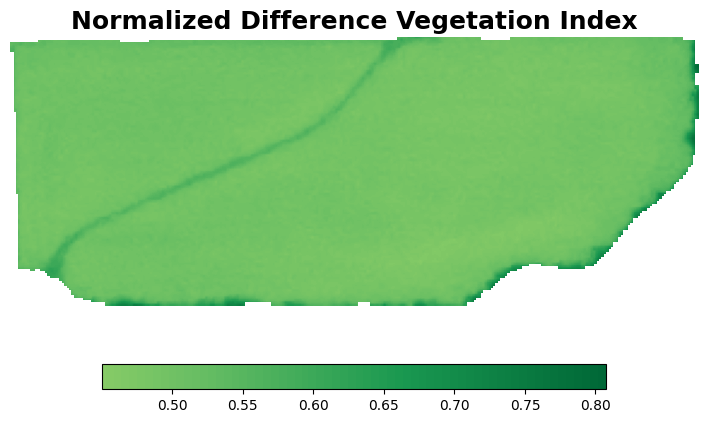

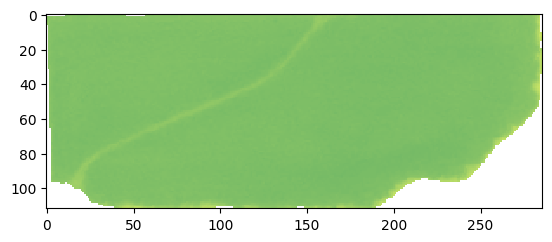

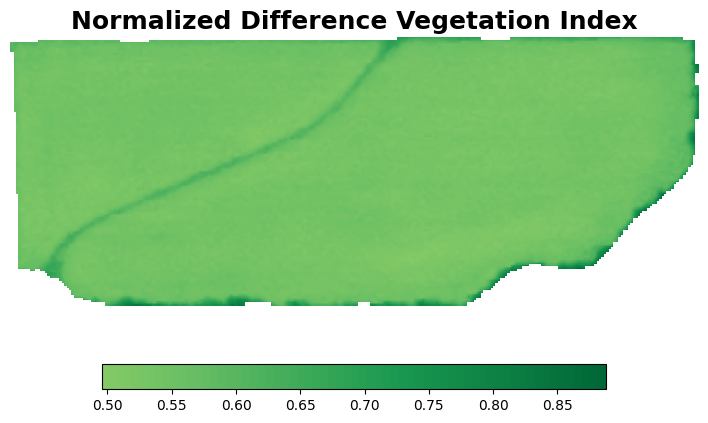

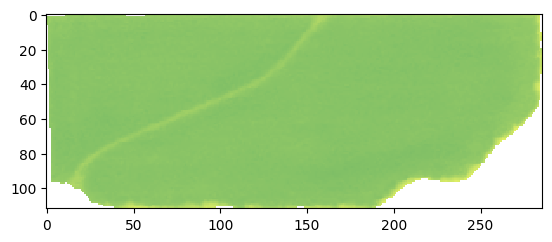

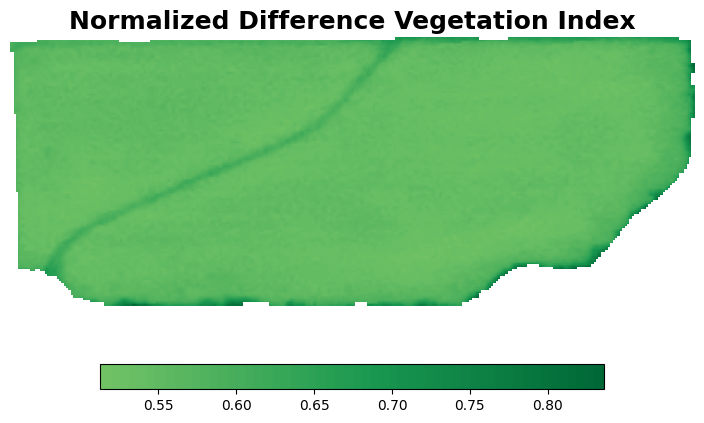

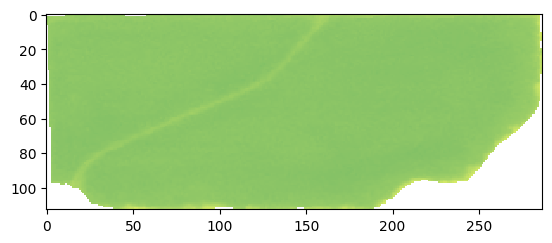

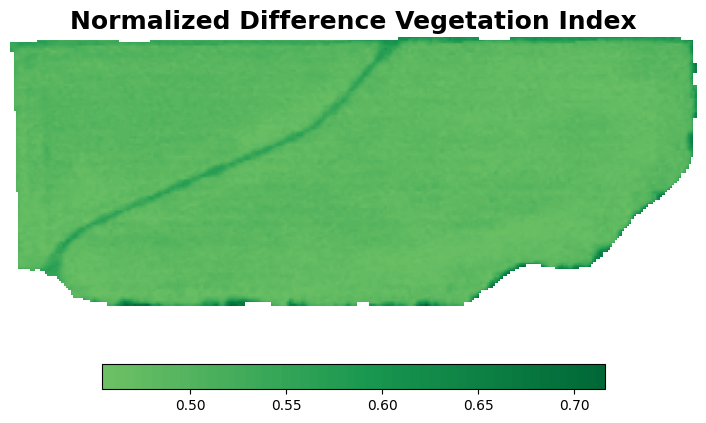

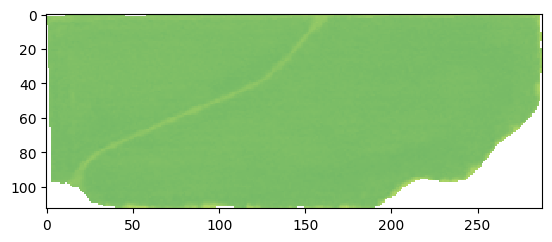

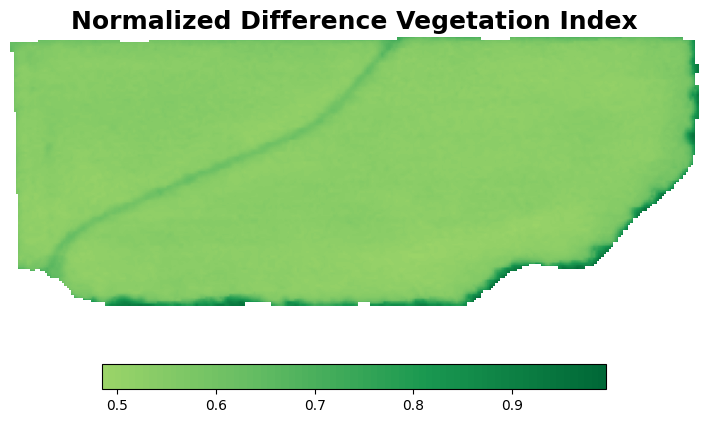

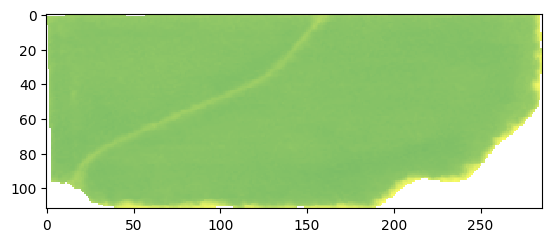

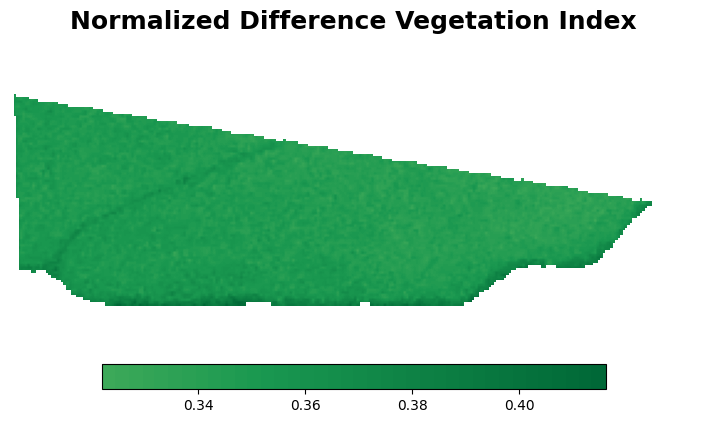

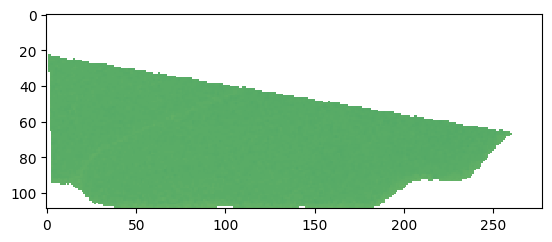

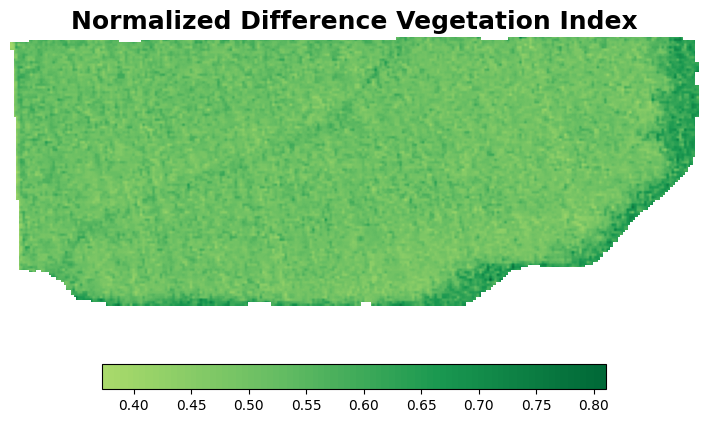

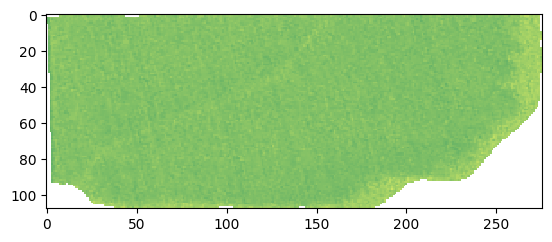

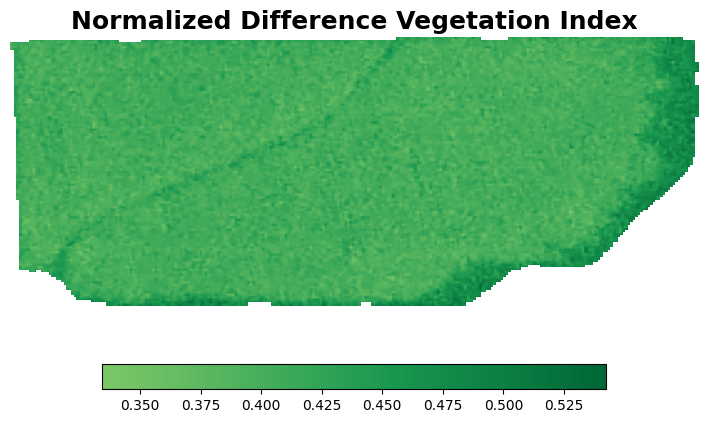

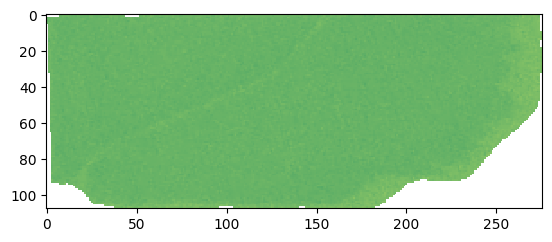

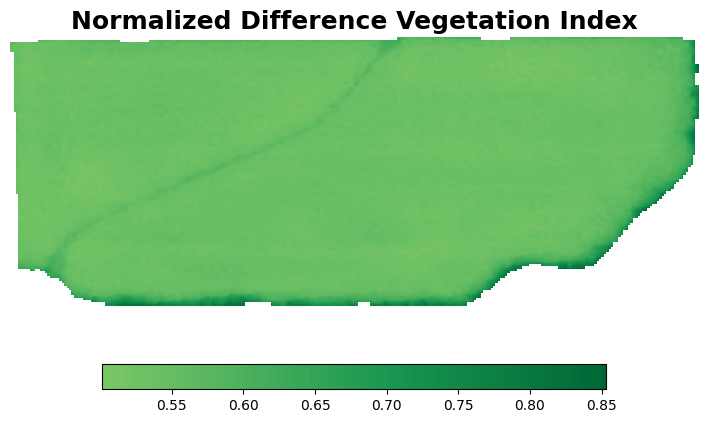

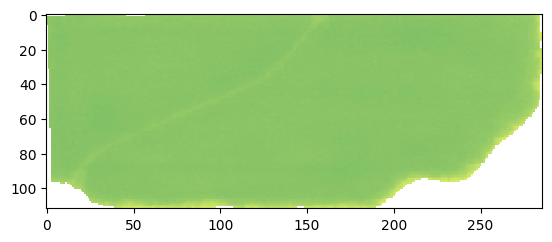

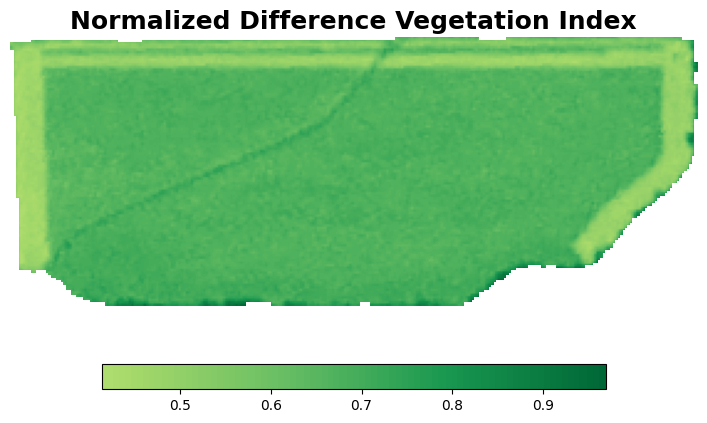

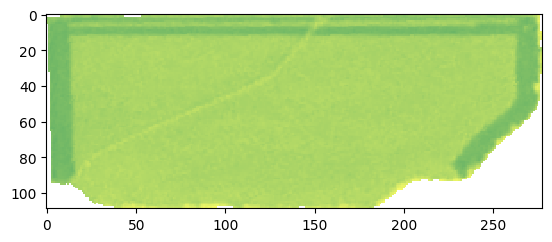

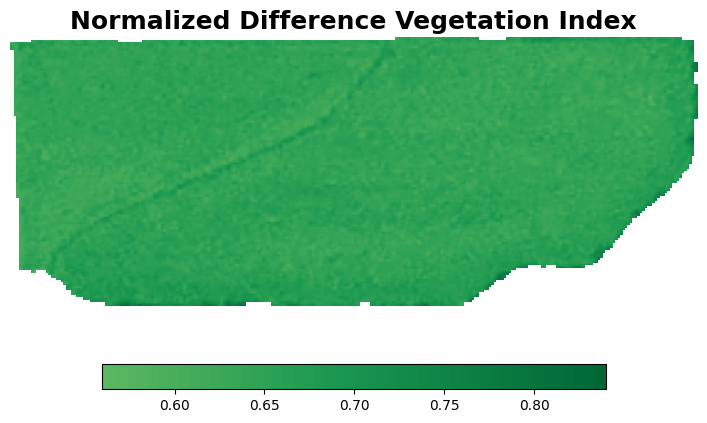

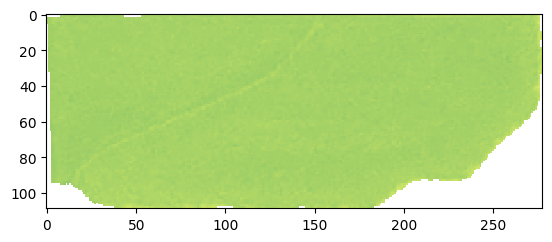

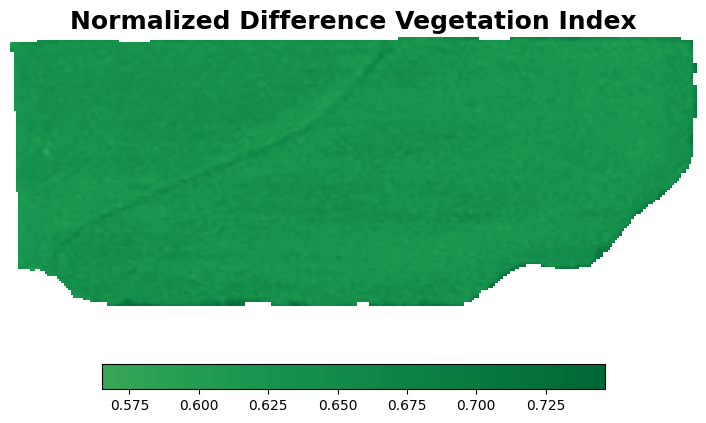

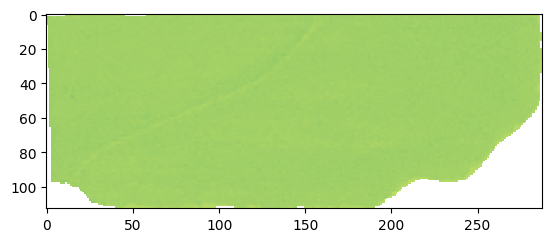

<ipython-input-11-8f0436ca5989>:26: RuntimeWarning: All-NaN slice encountered
  min=numpy.nanmin(ndvi)
<ipython-input-11-8f0436ca5989>:27: RuntimeWarning: All-NaN slice encountered
  max=numpy.nanmax(ndvi)


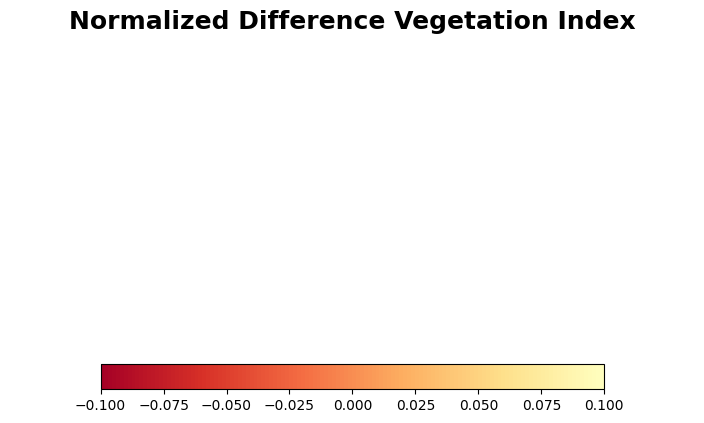

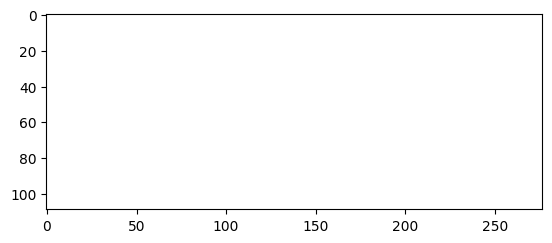

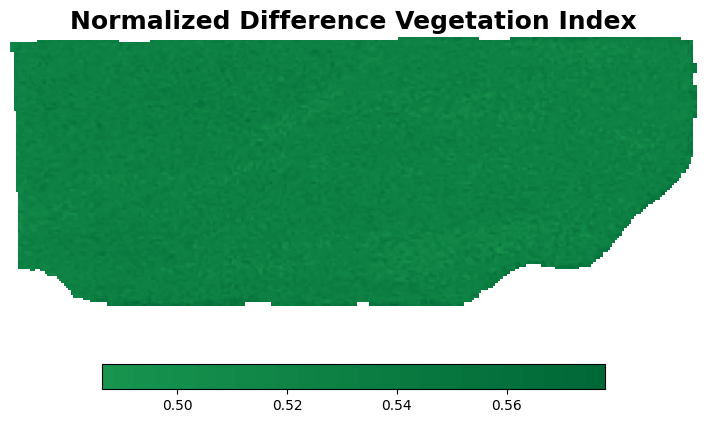

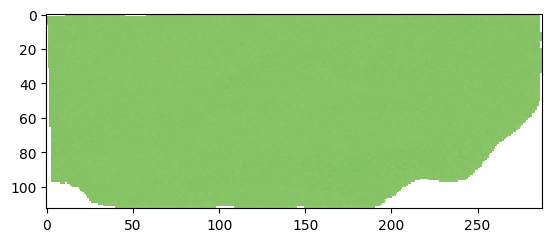

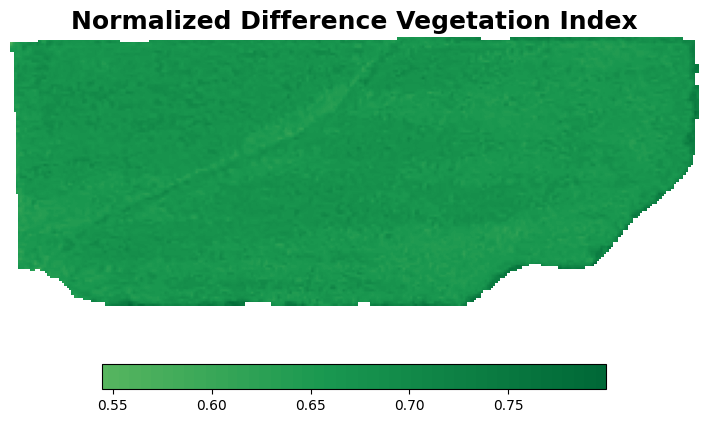

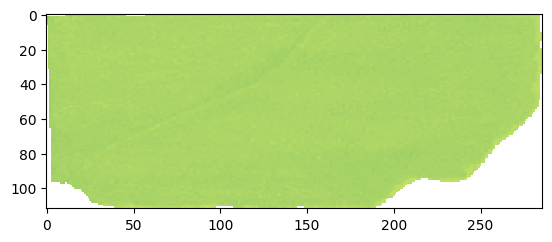

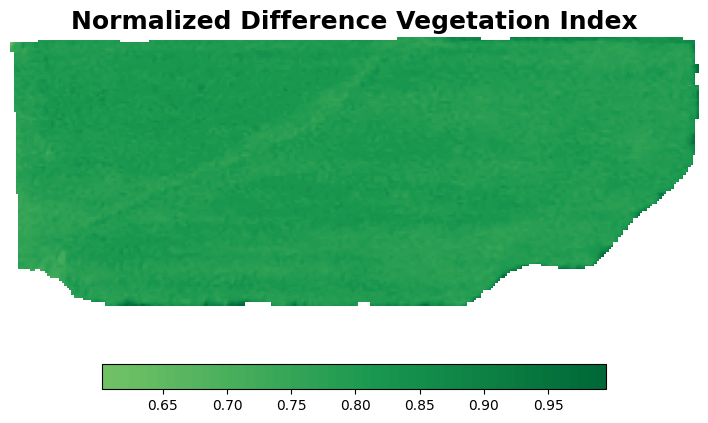

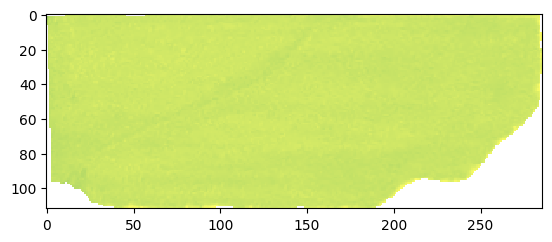

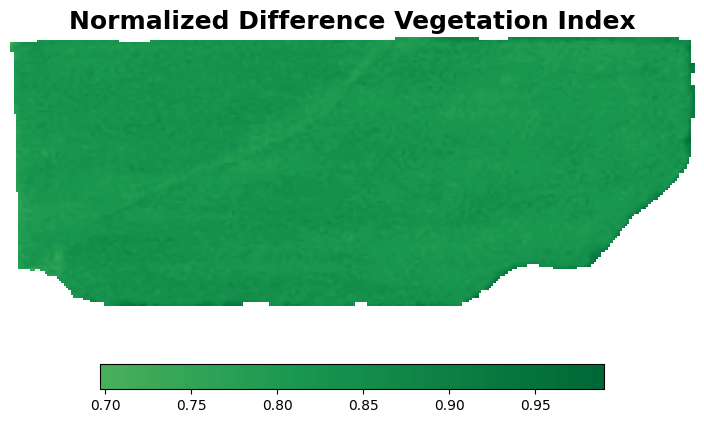

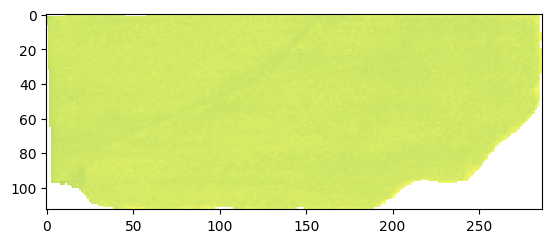

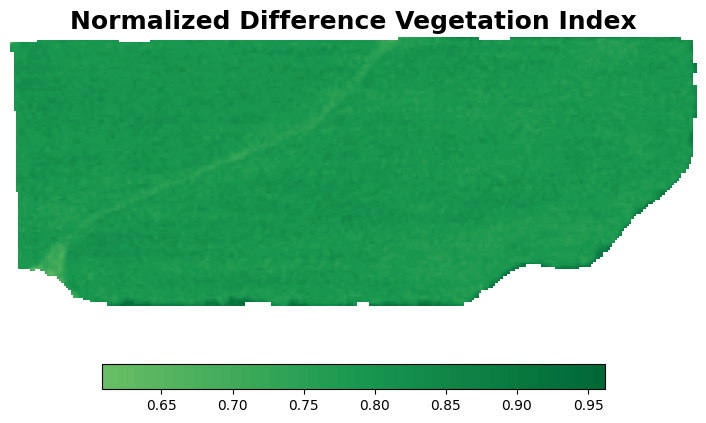

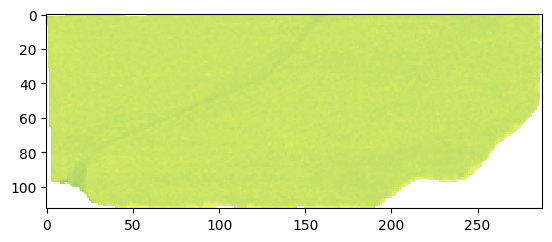

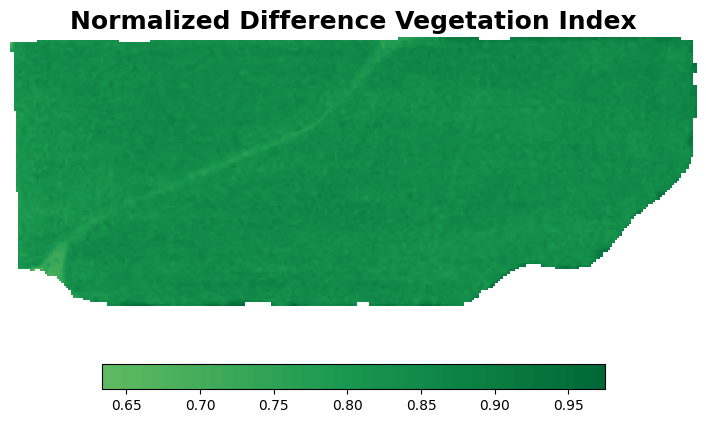

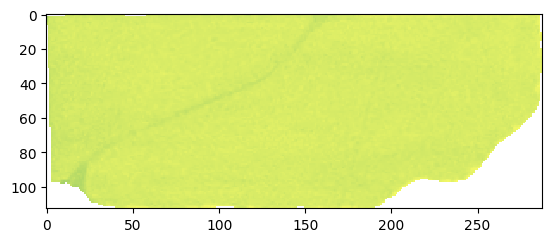

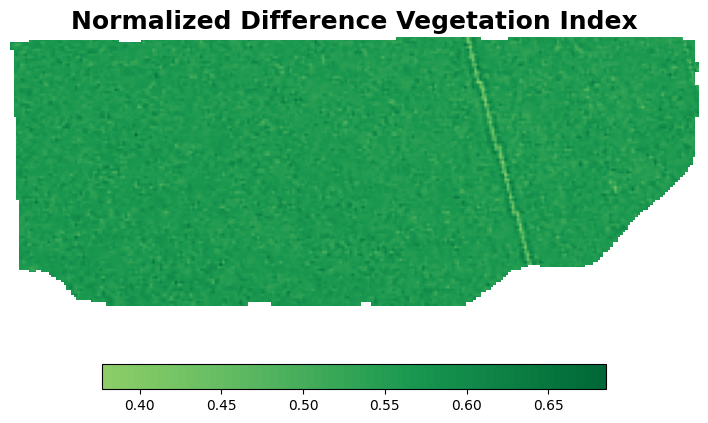

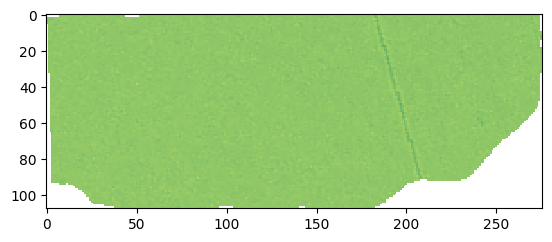

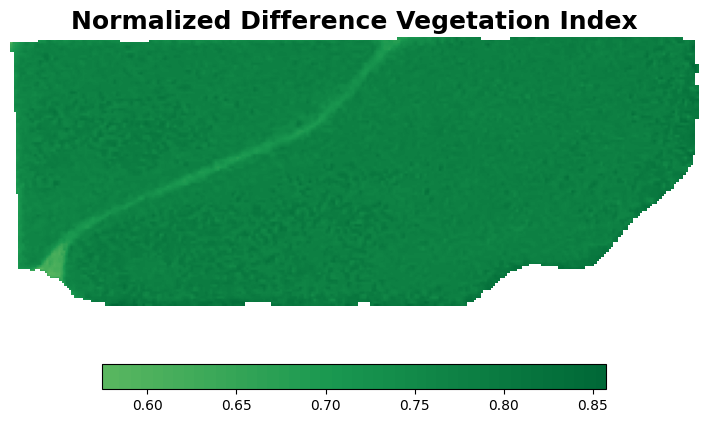

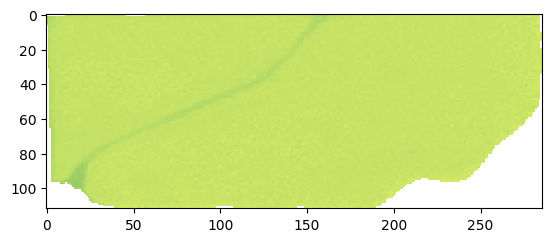

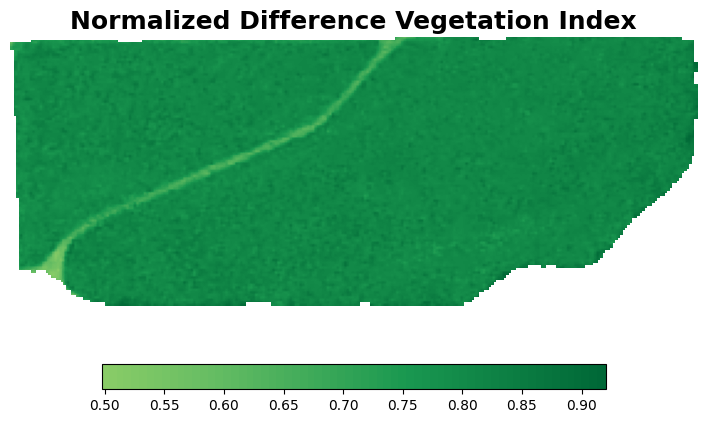

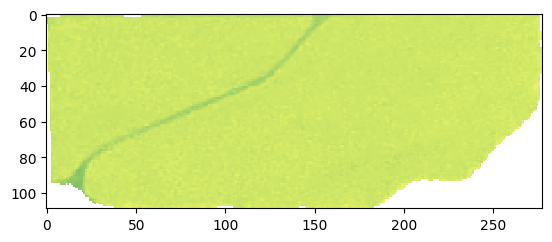

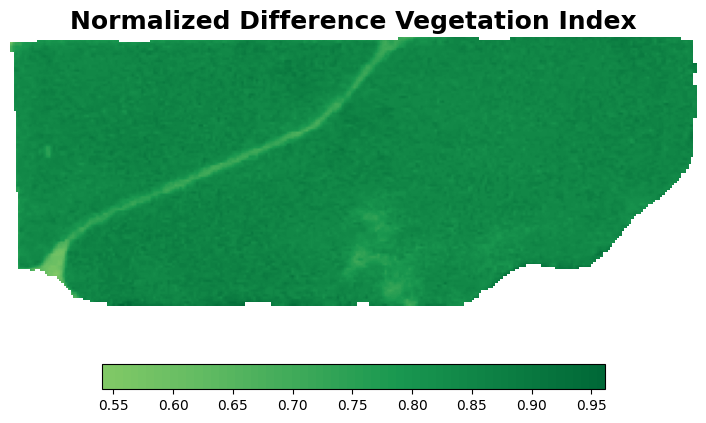

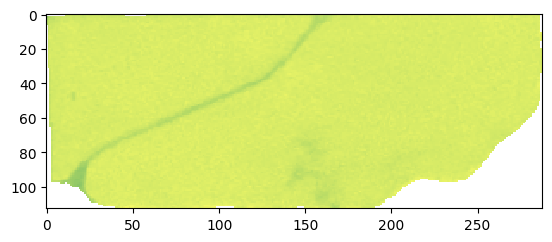

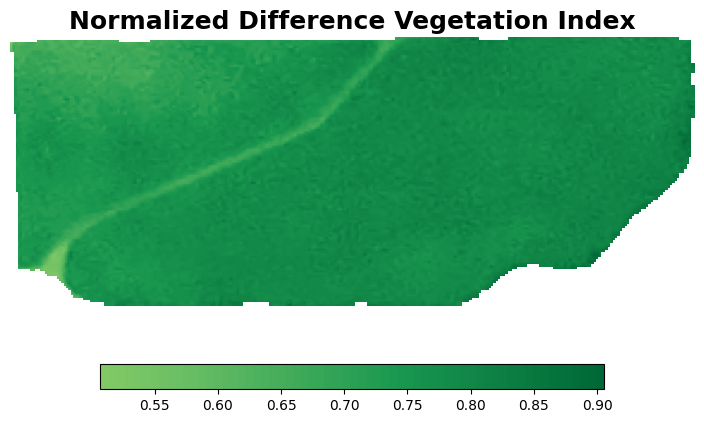

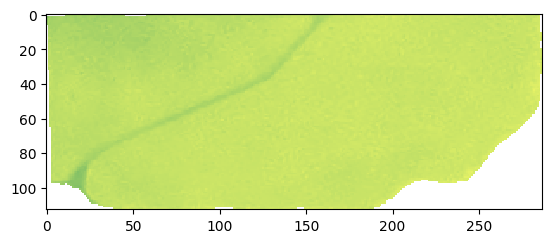

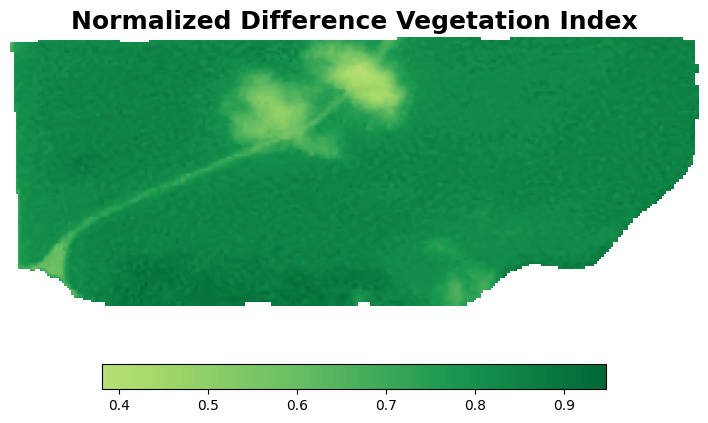

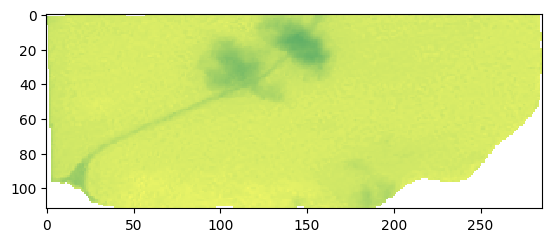

In [14]:
res = []
col = 1
for id_ in ids[2:]:
    image_path = f"data/imgs/{id_}_subarea.tif"
    out_path = f"data/ndvi/{id_}.tif"
    cmap_out_path = f"data/ndvi/{id_}_cmap.png"
    xml_path = f"data/imgs/{id_}_subarea.xml"
    for p in ['data/imgs', 'data/ndvi', 'data/plots']:
        if not os.path.exists(p):
            os.makedirs(p)
    trial_image = calc_ndvi(image_path,xml_path,out_path,cmap_out_path)
    ndvi_image_src = rasterio.open(out_path)
    #with rasterio.open('data/demo.tif', "w", **ndvi_image_src.meta) as dest:
    #    dest.write(ndvi_image_src.read(1), indexes=1)

    plt.imshow(ndvi_image_src.read(1), cmap=plt.cm.summer, interpolation='nearest',vmin=0, vmax=1)
    plt.show()
    # NO ndvi_image = ndvi_image_src.read(1)
    i = 0
    for geom in trial_design.iterrows():
        if not os.path.exists(f"data/plots/{id_}/"):
            os.makedirs(f"data/plots/{id_}/")
        plot_out_path = f"data/plots/{id_}/{i}.tif"
        plot_ndvi_image, plot_transform = rasterio.mask.mask(ndvi_image_src, geom[1], crop=True)
        #plt.imshow(plot_ndvi_image, cmap=plt.cm.summer)
        #plt.show()

        #plot_ndvi = plot_ndvi_image.read(1)
        out_meta = ndvi_image_src.meta
        out_meta.update(
            {
                "height": ndvi_image_src.shape[0],
                "width": ndvi_image_src.shape[1],
                "transform": plot_transform,
            }
        )
        with rasterio.open(plot_out_path, "w", **out_meta) as dest:
            dest.write(plot_ndvi_image.astype(rasterio.float32))
        plot_ndvi_image_opened = rasterio.open(plot_out_path)
        row = {}
        row['image_id'] = image_path
        row['plot_id'] = str(i)
        row['xml_path'] = xml_path
        row['ndvi_path'] = out_path
        row['max_ndvi'] = plot_ndvi_image.max()
        row['mean_ndvi'] = plot_ndvi_image.mean()
        row['median_ndvi'] = np.median(plot_ndvi_image)
        row['min_ndvi'] = plot_ndvi_image.min()
        res.append(row)
        if i != 155:#139:
            #pyplot.imshow(plot_ndvi_image_opened.read(1), cmap=plt.cm.summer, interpolation='nearest',vmin=0, vmax=1)
            
            # NO fig.add_subplot(i + 1, col, i + 1)
            #fig = plt.figure(figsize=(2, 1))
            #ax = fig.gca()
            #ax.set_axis_off()
            #ax.autoscale(False)
            #fig.add_subplot(139, 2, i+1)
            #plt.axis('off')
            #plt.imshow(plot_ndvi_image[0], cmap=plt.cm.summer)
            #plt.show()
            #print(image_path, str(i), plot_ndvi_image.mean())
            pass
        i += 1
    col += 1
    
    #break


In [15]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


nan

In [235]:
#saves results as a csv
import pandas as pd
df = pd.DataFrame(res)
df.to_csv('data/plot_results.csv', index=None)

'data/cropped/20210822_164358_51_2407/0.tiff'

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  20,  16,   0],
       [142, 100,  75, ...,  16,  14,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)